**Imports**


In [19]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt

tfds.disable_progress_bar() 


Data set


In [20]:
splits = ['train', 'test', 'test[90%:]'] 

(raw_train_data, raw_test_data, raw_validation_data), info = tfds.load("cars196", split= splits, with_info= True, as_supervised= True)


In [21]:
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes
print(num_examples)
print(num_classes)
print(info.features)

8144
196
FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})




*   Visulize the Dataset


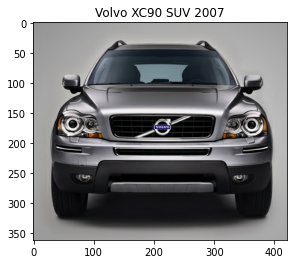

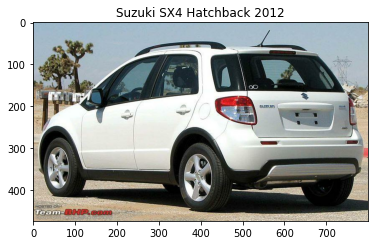

In [22]:
get_label_name = info.features['label'].int2str
for image, label in raw_train_data.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))



* Create list of labels



In [23]:
BATCH_SIZE = 32

In [24]:
IMAGE_SIZE = 224 # using 224 x 224 because that's what the pretrained mobile net model uses 
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3) # use a 224 x 224 image with rgb for the color data

In [25]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) / 255.0 # normlize data
  return image, label 

In [26]:
train_batches = raw_train_data.shuffle(1000).map(format_image).batch(BATCH_SIZE)
test_batches =raw_train_data.shuffle(1000).map(format_image).batch(1) #raw_test_data.map(format_image).batch(1)
validation_batches = raw_validation_data.map(format_image).batch(BATCH_SIZE)

In [27]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 224, 224, 3])

In [28]:
do_fine_tuning = False

In [29]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape= INPUT_SHAPE, 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)



In [31]:
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(512),
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               655872    
_________________________________________________________________
dense_3 (Dense)              (None, 196)               100548    
Total params: 3,014,404
Trainable params: 756,420
Non-trainable params: 2,257,984
_________________________________________________________________


In [32]:
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [33]:
history = model.fit(train_batches, epochs=10, validation_data=validation_batches)

Epoch 1/10
255/255 [==============================] - 37s 145ms/step - loss: 3.8540 - accuracy: 0.1612 - val_loss: 2.8032 - val_accuracy: 0.3221
Epoch 2/10
255/255 [==============================] - 36s 142ms/step - loss: 2.0456 - accuracy: 0.4710 - val_loss: 2.4789 - val_accuracy: 0.3806
Epoch 3/10
255/255 [==============================] - 36s 142ms/step - loss: 1.3396 - accuracy: 0.6433 - val_loss: 2.3290 - val_accuracy: 0.4154
Epoch 4/10
255/255 [==============================] - 35s 139ms/step - loss: 0.8877 - accuracy: 0.7688 - val_loss: 2.3252 - val_accuracy: 0.4328
Epoch 5/10
255/255 [==============================] - 36s 140ms/step - loss: 0.5887 - accuracy: 0.8536 - val_loss: 2.2973 - val_accuracy: 0.4453
Epoch 6/10
255/255 [==============================] - 36s 142ms/step - loss: 0.3981 - accuracy: 0.9035 - val_loss: 2.2469 - val_accuracy: 0.4465
Epoch 7/10
255/255 [==============================] - 36s 142ms/step - loss: 0.2594 - accuracy: 0.9470 - val_loss: 2.3614 - val_ac

### Save the labels to a file


In [34]:
import re
label_names = info.features['label'].names

for i in range(len(label_names)):
    name = label_names[i]
    name = re.sub("^n\d+-", "", name)
    name = re.sub("_", " ", name)
    label_names[i] = name + '\n'

with open("labels.txt", 'wt') as labels_file:
    labels_file.writelines(label_names)


### Optional manually test the model using an image of a dog from the internet



In [35]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
  x = image.img_to_array(img) 
  x = x / 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=512)
  index = np.argmax(classes)
  print("The image is: " + label_names[index])


Using TensorFlow backend.


### Export the model to tflite

In [36]:
DOGS_SAVED_MODEL = 'dog_detector_model'
tf.saved_model.save(model, DOGS_SAVED_MODEL)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: dog_detector_model/assets


INFO:tensorflow:Assets written to: dog_detector_model/assets


In [37]:
converter = tf.lite.TFLiteConverter.from_saved_model(DOGS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert() 
tflite_model_file = 'dog_detector_model.tflite'

with open(tflite_model_file, 'wb') as file:
  file.write(tflite_model)


### Test the TFLite Model Using the Python Interpreter

In [38]:
from tqdm import tqdm

interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()


input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
print(input_index)
print(output_index)
# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(20)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

0it [00:00, ?it/s]

0
179


20it [00:04,  4.48it/s]


In [39]:
# visulize the results make sure they work using the tensorflow lite interpreter. 
# this part of the code came from the tensorflow lite course on coursera.
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(label_names[predicted_label],
                                         100*np.max(predictions_array),
                                         label_names[true_label]), color=color)


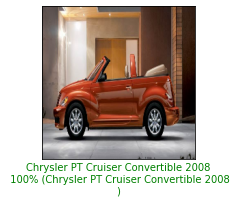

In [48]:
#@title Visualize the outputs { run: "auto" }
index = 5 #@param {type:"slider", min:0, max:19, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

### Download the tflite file

In [ ]:
try:
    from google.colab import files
    files.download(tflite_model_file)
    files.download('labels.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Optional Download Test Images

In [ ]:
!mkdir -p test_images

from PIL import Image

for index, (image, label) in enumerate(test_batches.take(100)):
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.squeeze(image).numpy()
    pil_image = Image.fromarray(image)
    pil_image.save('test_images/{}_{}.bmp'.format(label_names[label[0]], index))

!ls test_images
!zip -qq dogs_test_images.zip -r test_images/

'affenpinscher'$'\n''_33.bmp'
'affenpinscher'$'\n''_33.jpg'
'afghan hound'$'\n''_21.bmp'
'afghan hound'$'\n''_21.jpg'
'afghan hound'$'\n''_37.bmp'
'afghan hound'$'\n''_37.jpg'
'afghan hound'$'\n''_7.bmp'
'afghan hound'$'\n''_7.jpg'
'airedale'$'\n''_27.bmp'
'airedale'$'\n''_27.jpg'
'airedale'$'\n''_32.bmp'
'airedale'$'\n''_32.jpg'
'australian terrier'$'\n''_95.bmp'
'australian terrier'$'\n''_95.jpg'
'basset'$'\n''_10.bmp'
'basset'$'\n''_10.jpg'
'beagle'$'\n''_18.bmp'
'beagle'$'\n''_18.jpg'
'beagle'$'\n''_65.bmp'
'beagle'$'\n''_65.jpg'
'beagle'$'\n''_93.bmp'
'beagle'$'\n''_93.jpg'
'bedlington terrier'$'\n''_26.bmp'
'bedlington terrier'$'\n''_26.jpg'
'bedlington terrier'$'\n''_82.bmp'
'bedlington terrier'$'\n''_82.jpg'
'bernese mountain dog'$'\n''_4.bmp'
'bernese mountain dog'$'\n''_4.jpg'
'black-and-tan coonhound'$'\n''_76.bmp'
'black-and-tan coonhound'$'\n''_76.jpg'
'bloodhound'$'\n''_3.bmp'
'bloodhound'$'\n''_3.jpg'
'bluetick'$'\n''_71.bmp'
'bluetick'$'\n''_71.jpg'
'bluetick'$'\n''_90.

In [ ]:
from google.colab import files
try:
    files.download('dogs_test_images.zip')
except:
  
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>